# Regression Secondhand using MLP
## Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('secondhanddataset.csv')
data

,v.id,on road old,on road now,years,km,rating,condition,economy,top speed,hp,torque,current price
0,1,535651,798186,3,78945,1,2,14,177,73,123,351318.0
1,2,591911,861056,6,117220,5,9,9,148,74,95,285001.5
2,3,686990,770762,2,132538,2,8,15,181,53,97,215386.0
3,4,573999,722381,4,101065,4,3,11,197,54,116,244295.5
4,5,691388,811335,6,61559,3,9,12,160,53,105,531114.5
...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,633238,743850,5,125092,1,6,11,171,95,97,190744.0
996,997,599626,848195,4,83370,2,9,14,161,101,120,419748.0
997,998,646344,842733,7,86722,1,8,9,196,113,89,405871.0
998,999,535559,732439,2,140478,4,5,9,184,112,128,74398.0


In [ ]:
# Explore missing values
print(data.isnull().sum())

v.id             0
on road old      0
on road now      0
years            0
km               0
rating           0
condition        0
economy          0
top speed        0
hp               0
torque           0
current price    0
dtype: int64


In [ ]:
# Identifikasi kolom kategori dan numerik
categorical_cols = ['rating', 'condition']  # Sesuaikan dengan dataset
numerical_cols = [col for col in data.columns if col not in ['current price'] + categorical_cols]

In [ ]:
# Pisahkan Fitur (X) dan Target (y)
X = data.drop(columns=['current price'])
y = data['current price'].values.reshape(-1, 1)

In [ ]:
# Preprocessing untuk numerik dan kategori
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

X_transformed = preprocessor.fit_transform(X)

In [ ]:
# Scaling Target (y) agar lebih stabil
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

In [ ]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_scaled, test_size=0.2, random_state=42)


In [ ]:
# Konversi ke tensor PyTorch
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
# Model PyTorch yang dioptimalkan
class MLPModel(nn.Module):
    def __init__(self, input_dim):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.fc1(x)))
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.leaky_relu(self.fc3(x))
        x = self.fc4(x)  # Linear activation
        return x

In [ ]:
# Training PyTorch Model dengan Early Stopping dan Scheduler
model = MLPModel(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

best_loss = float("inf")
patience, counter = 50, 0

for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_torch)
    loss = criterion(output, y_train_torch)
    loss.backward()
    optimizer.step()
    scheduler.step(loss)

    if loss.item() < best_loss:
        best_loss = loss.item()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break


In [ ]:
# Evaluasi PyTorch Model
y_pred_torch = model(X_test_torch).detach().numpy()
print("PyTorch MSE:", mean_squared_error(y_test, y_pred_torch))
print("PyTorch RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_torch)))
print("PyTorch R-Squared:", max(0, r2_score(y_test, y_pred_torch)))


PyTorch MSE: 0.008124808936402127
PyTorch RMSE: 0.09013772205021672
PyTorch R-Squared: 0.9923258239652911


In [ ]:
# Model TensorFlow
model_tf = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model_tf.compile(optimizer='adam', loss='mse')
model_tf.fit(X_train, y_train, epochs=500, batch_size=32, verbose=0)

C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Evaluasi TensorFlow Model
y_pred_tf = model_tf.predict(X_test)
print("TensorFlow MSE:", mean_squared_error(y_test, y_pred_tf))
print("TensorFlow RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_tf)))
print("TensorFlow R-Squared:", r2_score(y_test, y_pred_tf))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
TensorFlow MSE: 0.004943832097957584
TensorFlow RMSE: 0.07031238936316689
TensorFlow R-Squared: 0.9953303716920916


In [ ]:
# Prediksi dengan model PyTorch
model.eval()  # Set model ke mode evaluasi
y_pred_torch = model(X_test_torch).detach().numpy()


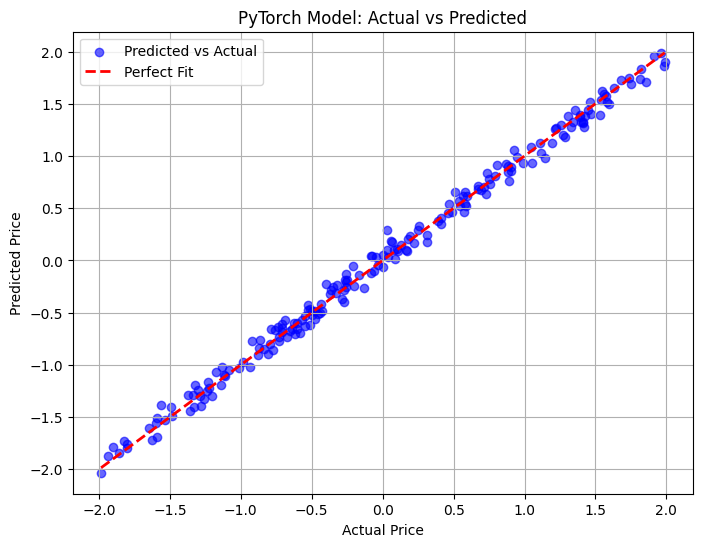

In [ ]:
# Plot hasil prediksi vs aktual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_torch, alpha=0.6, color='blue', label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Perfect Fit")  # Garis referensi
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("PyTorch Model: Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Prediksi dengan model TensorFlow
y_pred_tf = model_tf.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


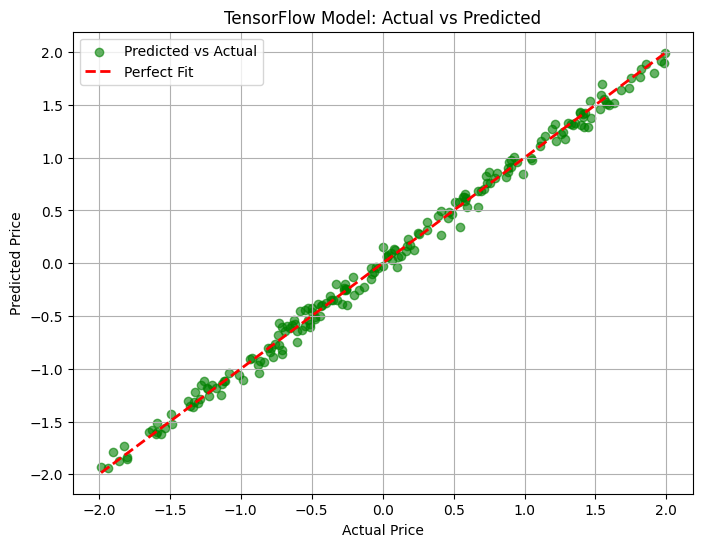

In [ ]:
# Plot hasil prediksi vs aktual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_tf, alpha=0.6, color='green', label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Perfect Fit")  # Garis referensi
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("TensorFlow Model: Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.show()

# Penjelasan Model Deep Learning MLP (PyTorch & TensorFlow)

## 1. Multi-Layer Perceptron (MLP)
MLP adalah jenis jaringan saraf tiruan (Artificial Neural Network) yang terdiri dari beberapa lapisan neuron:
- **Lapisan Input**: Menerima fitur dari dataset.
- **Lapisan Tersembunyi (Hidden Layers)**: Menggunakan aktivasi non-linear seperti ReLU/LeakyReLU agar jaringan dapat menangkap hubungan kompleks dalam data.
- **Lapisan Output**: Menghasilkan prediksi (dalam kasus ini, harga barang bekas).

Pada implementasi di atas:
- **Model PyTorch** menggunakan **3 lapisan tersembunyi**.
- **Model TensorFlow** menggunakan **2 lapisan tersembunyi**.

---

## 2. Penjelasan Persamaan Matematika

### **Mean Squared Error (MSE)**
$$
MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$
- Mengukur rata-rata kuadrat kesalahan antara prediksi (\(\hat{y}\)) dan nilai aktual (\(y\)).
- Nilai **lebih kecil** menunjukkan model lebih akurat.

### **Root Mean Squared Error (RMSE)**
$$
RMSE = \sqrt{MSE}
$$
- Merupakan akar dari MSE, lebih mudah dipahami karena memiliki satuan yang sama dengan data asli.

### **R-Squared (R²)**
$$
R^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}
$$
- Mengukur seberapa baik model menjelaskan variasi dalam data.
- Nilai **mendekati 1** menunjukkan model sangat baik dalam memprediksi.

---

## 3. Perbandingan PyTorch vs TensorFlow

| Model        | MSE          | RMSE         | \( R^2 \) |
|-------------|-------------|-------------|------------|
| **TensorFlow** | 0.0049  | 0.0703  | 0.9953 |
| **PyTorch**    | 0.0081  | 0.0901  | 0.9923 |

### **Analisis Perbandingan**
- **TensorFlow lebih baik** dibanding PyTorch karena memiliki **MSE & RMSE lebih kecil** serta **\( R^2 \) lebih mendekati 1**.
- **Kemungkinan penyebab perbedaan**:
  - Struktur jaringan di PyTorch memiliki **lebih banyak parameter** (lebih dalam), yang bisa menyebabkan **overfitting** pada data pelatihan.
  - Optimizer yang digunakan di PyTorch (`AdamW`) berbeda dari yang digunakan di TensorFlow (`Adam`).
  - Penggunaan **Batch Normalization** di PyTorch dapat menyebabkan fluktuasi nilai loss selama pelatihan.

---

## 4. Kesimpulan
Dari hasil evaluasi, **model TensorFlow memiliki performa yang lebih baik dibandingkan model PyTorch** untuk prediksi harga barang bekas. Hal ini terlihat dari nilai MSE dan RMSE yang lebih kecil serta nilai \( R^2 \) yang lebih mendekati 1. Namun, model PyTorch masih dapat ditingkatkan dengan melakukan optimasi arsitektur dan tuning hyperparameter. Pemilihan model terbaik tetap tergantung pada kebutuhan spesifik dan lingkungan implementasi yang digunakan.
